In [1]:
# Standard python imports
import os
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm, tnrange, tqdm_notebook

# Keras, tf, and sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Try seeing if we are using a gpu?
from keras import backend as K
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.set_session(sess)
print("Using gpu: ", K.tensorflow_backend._get_available_gpus())

# Make reproducible
SEED = 32
np.random.seed(SEED)
tf.set_random_seed(SEED)

# My module imports
import utils
from make_models import model_1d

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Using gpu:  ['/job:localhost/replica:0/task:0/device:GPU:0']


# Data Processing

In [2]:
# Maybe get the data .mat file
if not os.path.isfile("data.mat"):
    !wget https://www.dropbox.com/s/b1bnrj2f30xe1ns/xq_data_big.mat?dl=0
    !mv 'xq_data_big.mat?dl=0' data.mat

# Import the data from file
f = h5py.File("data.mat")
data_0, labels_0 = np.array(f['data']), np.array(f['labels'])
f.close()

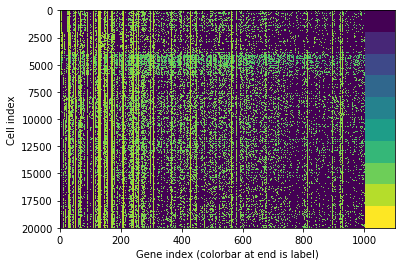

In [3]:
colInds = pd.read_csv("assets/divergences.csv")["Gene_index"].values[:1000]
#colInds = np.where(np.sum(data, axis=0) != 0.0)[0]
data = utils.preprocess(data_0, colInds)

## Quickly check I'm not crazy
#indices_in_orig = pd.read_csv("assets/divergences.csv")["Gene_index"].values # Values in original data_matrix
#indices = [list(colInds).index(ind) for ind in indices_in_orig] # Values in sliced data_matrix (no zero_columns)
#zero_cols = np.array(indices[300:])
#data[:, zero_cols] = 0

# Labels are off by 1 cuz matlab
labels = labels_0.squeeze().astype(int) - 1

utils.visualize_data(data, labels);

In [4]:
# Parameters to use for the rest of this workflow
BATCH_SIZE = 60
TEST_PROP = 0.1
VAL_PROP = 0.1
NCLASS = 10
NFEATURES = data.shape[1]

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


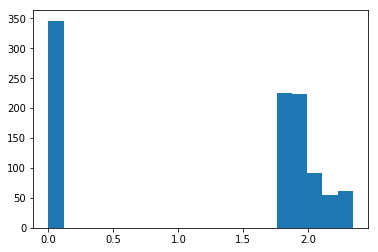

In [5]:
# Get test and training
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=TEST_PROP)

# Convert labels to one-hot format
train_labels = (np.arange(NCLASS) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(NCLASS) == test_labels[:, None]).astype(np.float32)

# Sanity check to make sure data is not crazy
plt.subplot(111).hist(train_data[0].flatten(), bins=20)
print(train_labels[0])

In [6]:
# Reshape the data
test_data = test_data[:, :, None, None]
train_data = train_data[:, :, None, None]

# Model Definition

In [7]:
model = model_1d(NFEATURES, conv_channels=[], dense_neurons=[2048, 512], n_class=NCLASS, \
                 conv_ks=[], \
                 pool_ks=[], \
                 pads=[], \
                 dropout_strength=0.8, regs=0.01)

#model = model_1d(NFEATURES, conv_channels=[16, 16, 32, 64, 128], dense_neurons=[512], n_class=NCLASS, \
#                 conv_ks=[20, 10, 10, 2, 5], \
#                 pool_ks=[2, 4, 4, 4, 3], \
#                 pads=['same', 'same', 'same', 'valid', 'same'], \
#                 pool_type='max',\
#                 dropout_strength=0.5, regs=0.01)

Instructions for updating:
Colocations handled automatically by placer.


# Training / Evaluation

In [8]:
model.fit(train_data, train_labels, 
          batch_size=BATCH_SIZE, epochs=10,\
          validation_split=VAL_PROP, verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 16200 samples, validate on 1800 samples
Epoch 1/10
16200/16200 [==============================] - 3s 161us/step - loss: 5.8573 - acc: 0.5896 - val_loss: 1.2893 - val_acc: 0.8189
Epoch 2/10
16200/16200 [==============================] - 2s 109us/step - loss: 1.1447 - acc: 0.7618 - val_loss: 0.9026 - val_acc: 0.7950
Epoch 3/10
16200/16200 [==============================] - 2s 107us/step - loss: 0.8708 - acc: 0.7981 - val_loss: 0.6789 - val_acc: 0.8394
Epoch 4/10
16200/16200 [==============================] - 2s 109us/step - loss: 0.7865 - acc: 0.8116 - val_loss: 0.7073 - val_acc: 0.8267
Epoch 5/10
16200/16200 [==============================] - 2s 107us/step - loss: 0.7272 - acc: 0.8299 - val_loss: 0.7071 - val_acc: 0.8350
Epoch 6/10
16200/16200 [==============================] - 2s 106us/step - loss: 0.6981 - acc: 0.83

In [9]:
loss, acc = model.evaluate(test_data, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

2000/2000 [==============================] - 0s 39us/step
Test loss: 0.6572320287227631
Test accuracy: 0.843


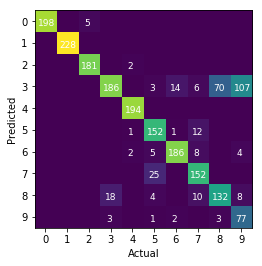

In [17]:
preds = model.predict(test_data)
conf = utils.confusions(preds, test_labels)
utils.plot_confusions(conf);

In [18]:
mets = {'Class': np.arange(NCLASS)}
mets.update({metric:utils.perf_metric(preds, test_labels, metric=metric) for metric in ['precision', 'recall']})
df = pd.DataFrame(mets)
df

,Class,precision,recall
0,0,0.975369,1.000000
1,1,1.000000,1.000000
2,2,0.989071,0.973118
3,3,0.481865,0.898551
4,4,1.000000,0.974874
5,5,0.915663,0.800000
6,6,0.907317,0.916256
7,7,0.858757,0.808511
8,8,0.767442,0.643902
9,9,0.895349,0.392857


# Saving / Summary

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2050048   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 3,104,266
Trainable params: 3,104,266
Non-trainable params: 0
_________________________________________________________________


In [13]:
fName = "test_model.h5"
model.save(fName)

# Reloading saved model

In [14]:
from keras.models import load_model
model = load_model("test_model.h5")

In [15]:
loss, acc = model.evaluate(train_data, train_labels)
print(f"Train loss: {loss}")
print(f"Train accuracy: {acc}")

18000/18000 [==============================] - 1s 43us/step
Train loss: 0.5836345889303419
Train accuracy: 0.862


In [16]:
loss, acc = model.evaluate(test_data, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

2000/2000 [==============================] - 0s 37us/step
Test loss: 0.6572320516109467
Test accuracy: 0.843
